In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import keras_tuner as kt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
train_dataset_path = "C:/Users/Hemanth Kumar Reddy/Documents/NNDL/Image2/archive (2)/asl_alphabet_train/asl_alphabet_train"
test_dataset_path = "C:/Users/Hemanth Kumar Reddy/Documents/NNDL/Image2/archive (2)/asl_alphabet_test/asl_alphabet_test"


In [3]:
img_size = (64, 64)
batch_size = 32

In [4]:
try:
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dataset_path,
        image_size=img_size,
        batch_size=batch_size,
        seed=42,
        validation_split=0.2,
        subset="training"
    )
    val_ds = tf.keras.utils.image_dataset_from_directory(
        train_dataset_path,
        image_size=img_size,
        batch_size=batch_size,
        seed=42,
        validation_split=0.2,
        subset="validation"
    )
    class_names = train_ds.class_names
    num_classes = len(class_names)
    print(f"Classes: {class_names}")

    normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

    train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()



Found 86994 files belonging to 29 classes.
Using 69596 files for training.
Found 86994 files belonging to 29 classes.
Using 17398 files for validation.
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [5]:
def build_hybrid_model(hp):
    model = models.Sequential()

    model.add(layers.Conv2D(
        filters=hp.Choice("filters_0", [32, 64, 128]),
        kernel_size=(3, 3),
        activation='relu',
        input_shape=(64, 64, 3)  
    ))
    model.add(layers.MaxPooling2D((2, 2)))

    
    for i in range(1, hp.Int("conv_layers", 2, 3)):  
        model.add(layers.Conv2D(
            filters=hp.Choice(f"filters_{i}", [32, 64, 128]),
            kernel_size=(3, 3),
            activation='relu'
        ))
        model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())


    for i in range(hp.Int("dense_layers", 1, 2)): 
        model.add(layers.Dense(
            units=hp.Choice(f"dense_units_{i}", [256, 512, 1024]),
            activation='relu'
        ))
        model.add(layers.Dropout(hp.Float("dropout", 0.2, 0.5, step=0.1)))


    model.add(layers.Dense(num_classes, activation='softmax'))

    learning_rate = hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [6]:
tuner = kt.RandomSearch(
    build_hybrid_model,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=1,
    directory="tuner_results",
    project_name="asl_sign_language"
)

Reloading Tuner from tuner_results\asl_sign_language\tuner0.json


In [7]:
tuner.search(train_ds, validation_data=val_ds, epochs=5, callbacks=[EarlyStopping(monitor='val_loss', patience=2)])


In [8]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters found:", best_hps.values)


Best hyperparameters found: {'conv_layers': 2, 'filters_0': 64, 'filters_1': 128, 'dense_layers': 2, 'dense_units_0': 256, 'dropout': 0.2, 'learning_rate': 0.001, 'filters_2': 64, 'dense_units_1': 256}


In [9]:
best_model = tuner.hypermodel.build(best_hps)


C:\Users\Hemanth Kumar Reddy\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
checkpoint = ModelCheckpoint("Project.keras", monitor="val_loss", save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [11]:
history = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 829s 375ms/step - accuracy: 0.4937 - loss: 1.6562 - val_accuracy: 0.9596 - val_loss: 0.1257
Epoch 2/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 823s 378ms/step - accuracy: 0.9310 - loss: 0.1967 - val_accuracy: 0.9847 - val_loss: 0.0518
Epoch 3/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 825s 379ms/step - accuracy: 0.9635 - loss: 0.1057 - val_accuracy: 0.9872 - val_loss: 0.0394
Epoch 4/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 822s 378ms/step - accuracy: 0.9741 - loss: 0.0796 - val_accuracy: 0.9891 - val_loss: 0.0300
Epoch 5/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 827s 380ms/step - accuracy: 0.9802 - loss: 0.0611 - val_accuracy: 0.9959 - val_loss: 0.0133
Epoch 6/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 821s 377ms/step - accuracy: 0.9837 - loss: 0.0519 - val_accuracy: 0.9928 - val_loss: 0.0224
Epoch 7/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 826s 380ms/step - accuracy: 0.9846 - loss: 0.0499 - val_accuracy: 0.9948 - val_loss: 0.0190
Epoch 8/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 824s 379ms/step - ac

In [12]:
best_model.build((None, 64, 64, 3)) 
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 29)                  │           7,453 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,715,033 (75.21 MB)

 Trainable params: 6,571,677 (25.07 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,143,356 (50.14 MB)

In [13]:
def load_test_images(test_path, img_size):
    test_images = []
    test_filenames = []

    for img_name in os.listdir(test_path):
        img_path = os.path.join(test_path, img_name)
        img = image.load_img(img_path, target_size=img_size)
        img_array = image.img_to_array(img) / 255.0 
        test_images.append(img_array)
        test_filenames.append(img_name)

    return np.array(test_images), test_filenames

In [14]:
test_images, test_filenames = load_test_images(test_dataset_path, img_size)


In [15]:
predictions = best_model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step


In [16]:
for i in range(min(5, len(test_filenames))):  
    print(f"Test Image: {test_filenames[i]} | Predicted Class: {class_names[predicted_classes[i]]}")


Test Image: A_test.jpg | Predicted Class: A
Test Image: B_test.jpg | Predicted Class: B
Test Image: C_test.jpg | Predicted Class: C
Test Image: D_test.jpg | Predicted Class: D
Test Image: E_test.jpg | Predicted Class: E


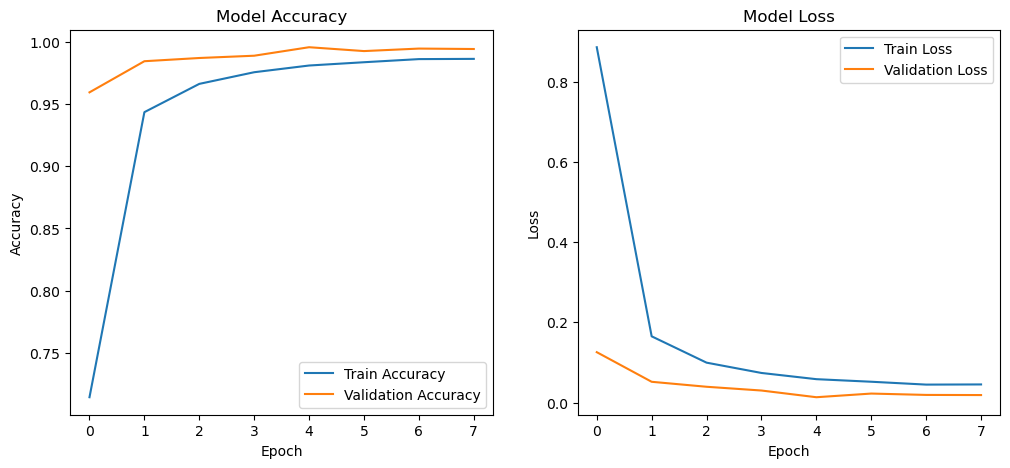

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy graph
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].legend()

# Loss graph
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss')
axes[1].legend()

plt.show()

In [18]:
test_loss, test_acc = best_model.evaluate(val_ds)
print(f"Validation Accuracy: {test_acc:.4f}")


544/544 ━━━━━━━━━━━━━━━━━━━━ 59s 108ms/step - accuracy: 0.9958 - loss: 0.0128
Validation Accuracy: 0.9959


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

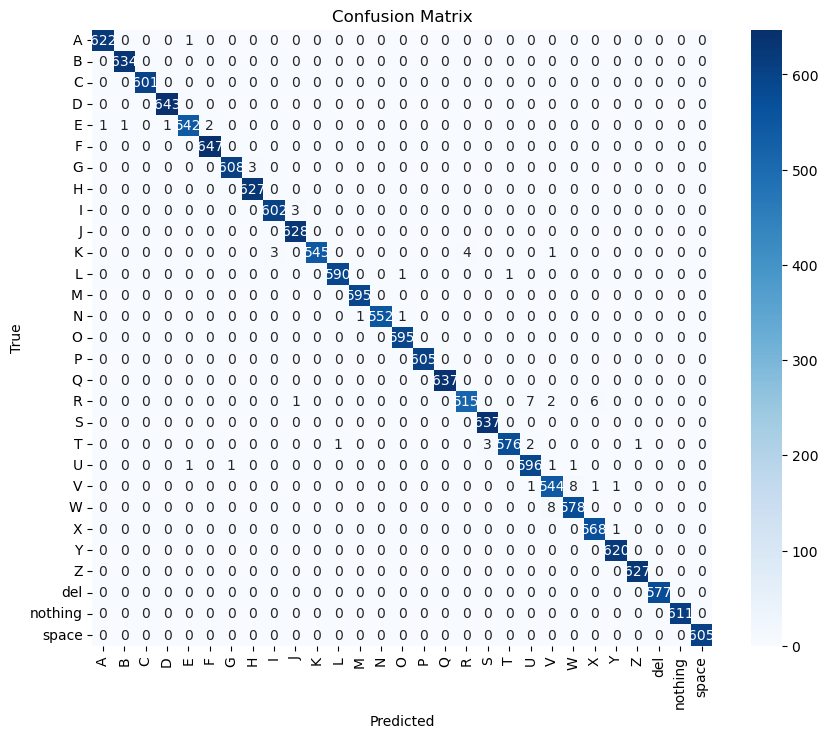

In [19]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = best_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
